In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imageio import imread

import sys

sys.path.insert(0, "../src")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction

utils.plot_settings()  # LaTeX fonts in Plots!

FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents
SEEDVAL = 2018

In [2]:
n=200 # Try 200, and try 1000
noise_scale=0.2 # Try 0, and try 0.2
max_degree=15 # Don't increase without increasing number of points
n_bootstraps=100
k_folds=5
n_lambdas=30
do_boot=True # To save computation time, set to False. Will then give empty plots of bias-variance-analysis
do_subset=True # To save computation time, set to False. Will then not perform bias-variance-analysis for
                # a subset of lambdas different from the estimated optimal.

np.random.seed(SEEDVAL)
# n = 500
# noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
# max_degree = 15
# n_lambdas = 30
# n_bootstraps = 100
# k_folds = 5
lambdas = np.logspace(-6, 0, n_lambdas)
subset_lambdas = np.logspace(-6,0,7)

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    if do_boot:
        # All regression bootstraps at once
        lamb_ridge = best_ridge_lambda[degree_index]
        lamb_lasso = best_lasso_lambda[degree_index]

        (
            ridge_mse,
            ridge_bias,
            ridge_variance,
            lasso_mse,
            lasso_bias,
            lasso_variance,
            ols_mse,
            ols_bias,
            ols_variance,
        ) = bootstrap.bootstrap_all(
            X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
        )

        (
            ridge_best_lambda_boot_mse[degree_index],
            ridge_best_lambda_boot_bias[degree_index],
            ridge_best_lambda_boot_variance[degree_index],
        ) = (ridge_mse, ridge_bias, ridge_variance)

        (
            lasso_best_lambda_boot_mse[degree_index],
            lasso_best_lambda_boot_bias[degree_index],
            lasso_best_lambda_boot_variance[degree_index],
        ) = (lasso_mse, lasso_bias, lasso_variance)

        ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
            ols_mse,
            ols_bias,
            ols_variance,
        )

    if do_subset:
        # Bootstrapping for a selection of lambdas for ridge and lasso
        subset_lambda_index = 0
        for lamb in subset_lambdas:

            (
                ridge_mse,
                ridge_bias,
                ridge_variance,
                lasso_mse,
                lasso_bias,
                lasso_variance,
            ) = bootstrap.bootstrap_ridge_lasso(
                X_train_scaled,
                X_test_scaled,
                z_train,
                z_test,
                n_bootstraps,
                lamb_lasso,
                lamb_ridge,
            )

            (
                ridge_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (ridge_mse, ridge_bias, ridge_variance)

            (
                lasso_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (lasso_mse, lasso_bias, lasso_variance)

            subset_lambda_index += 1


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.243894602843288, tolerance: 0.001989706469268973
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1534679400253576, tolerance: 0.001867401715918884
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.13442989561778, tolerance: 0.0019230558813845328
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2135071596283744, tolerance: 0.0017332853228179507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.423745374608538, tolerance: 0.0018266178971544005
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7231299986985662, tolerance: 0.0017892602944765757
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9941381551978599, tolerance: 0.0017939342180197473
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.557131669702895, tolerance: 0.0018653582254497035
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.257312820456047, tolerance: 0.00196063731125277
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8282391104856814, tolerance: 0.0015225839212129845
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1862457528797337, tolerance: 0.0021414221296005313
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4841050287148942, tolerance: 0.002113384243684815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2097217974780046, tolerance: 0.001771458617259722
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2470034625875837, tolerance: 0.002293687944795183
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7023529230997292, tolerance: 0.0021058390417260336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.312117798053033, tolerance: 0.0019213582622173615
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8489244587886393, tolerance: 0.0018729585059750627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.718295434048849, tolerance: 0.0015535671696018994
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7966737298927942, tolerance: 0.0014701614290168977
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4526704179638092, tolerance: 0.001315332466760649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4847953198473847, tolerance: 0.002117868670761392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.128410884107178, tolerance: 0.0022171231711692056
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0762715231275144, tolerance: 0.0017175859346930367
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.578465478682052, tolerance: 0.001797782932426474
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2650897249517519, tolerance: 0.0013196985646191802
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9138340034062304, tolerance: 0.0018475534962148566
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6321538376248363, tolerance: 0.0017211859856479073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8043260689497016, tolerance: 0.0019914572732407324
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2178043729521746, tolerance: 0.0020079472401257014
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.171766530675824, tolerance: 0.0018632610660739475
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18234141975358842, tolerance: 0.0013733324100874981
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17702482282099208, tolerance: 0.0021746232404254878
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09258285265175203, tolerance: 0.0015754844734905437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11084595641843009, tolerance: 0.002045075373875833
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09098361558077439, tolerance: 0.0017832082239798404
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14662445254163803, tolerance: 0.002415498837555115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2679091197517014, tolerance: 0.0019750317655553755
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00381496364625189, tolerance: 0.0018900585138911605
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31101597908579404, tolerance: 0.001964225374088498
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08836344343496805, tolerance: 0.0017584121068518997
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37121993935717423, tolerance: 0.001894648629072295
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004594815313520684, tolerance: 0.0017759149186782224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20521647451361869, tolerance: 0.001770643831545078
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13489433669974282, tolerance: 0.0018804333417917342
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04835952285324563, tolerance: 0.0014377289573870968
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04252894103579141, tolerance: 0.0020369444044546067
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003641722705546968, tolerance: 0.0022070619310898872
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029666702331277328, tolerance: 0.001632325579995329
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13200606120837133, tolerance: 0.0016328861824661013
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04952897657956434, tolerance: 0.001991045556691101
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029532637863798783, tolerance: 0.0016328282200640388
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010883562799967272, tolerance: 0.0016251439566739613
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16823635468889453, tolerance: 0.0016565536114165383
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007325686041515844, tolerance: 0.0019413367757850609
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08674065303412704, tolerance: 0.0019446356138051834
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1504736005574907, tolerance: 0.0018285567722135317
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006221907859449871, tolerance: 0.0014895759960463814
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13035802575069866, tolerance: 0.0019180871573517516
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06924689078932555, tolerance: 0.001657674021346361
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012285564261270032, tolerance: 0.001413003021964494
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8510671853232687, tolerance: 0.0017789911537478905
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6753088389197908, tolerance: 0.0019663358433779587
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.864514643419882, tolerance: 0.0019951136800842283
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.653303331358878, tolerance: 0.0019002958907719098
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2161881945439896, tolerance: 0.0019149757343226623
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.010144866764757, tolerance: 0.0016793755030839307
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2361056004654027, tolerance: 0.001619126746214157
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5278661482169156, tolerance: 0.0018242252357468993
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8500761274638706, tolerance: 0.0016893365669207207
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.325956297285434, tolerance: 0.0019346523946415911
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8442405605120296, tolerance: 0.0018636261846288922
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1902250411543105, tolerance: 0.0016917124447265509
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.155117382155616, tolerance: 0.001837321899389383
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1779221822584214, tolerance: 0.001962021653104668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4191632051318237, tolerance: 0.0014133494380612547
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3846972566545133, tolerance: 0.0018374942478047716
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.062874683093843, tolerance: 0.0015773391865725917
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7407407715799708, tolerance: 0.0019130787848976802
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.924252050890602, tolerance: 0.0020356292067269053
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.965055284900282, tolerance: 0.0019360781111668402
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.964384596102791, tolerance: 0.00188099459404935
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2917715502800213, tolerance: 0.001870721592610781
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9524226797603024, tolerance: 0.0016022678138249604
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.13114272082872, tolerance: 0.0015813823447653865
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.663894998408726, tolerance: 0.001746028850329445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2200616858590263, tolerance: 0.001846340344698546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2609356758547, tolerance: 0.0020437081124024576
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1278327422184464, tolerance: 0.001809481311794772
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8809260712121298, tolerance: 0.0018810193998411797
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.492566531065985, tolerance: 0.001984353150538876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1180677013990508, tolerance: 0.001728523470104267
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.00162250381311, tolerance: 0.0015478821119713556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6407972746614723, tolerance: 0.0020600869179961748
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4050579384669275, tolerance: 0.001971366321339371
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.993851324510752, tolerance: 0.0017380375122225318
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.076005353208859, tolerance: 0.0016320145108623713
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2547745268238293, tolerance: 0.0016104071736158783
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5916847658059807, tolerance: 0.002667263222993275
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.042700436650743, tolerance: 0.0017193474727477296
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.318524552902473, tolerance: 0.0019250518042177405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5617190003424097, tolerance: 0.0021965007582781804
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1683613087614804, tolerance: 0.002057432209213932
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.756487844371637, tolerance: 0.0015168509928257727
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4277098404071706, tolerance: 0.0019032246623395556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.741241768777611, tolerance: 0.0016168570933852721
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9455801132130779, tolerance: 0.0016375288542000085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0927157092823747, tolerance: 0.001893185574358168
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.918792056871593, tolerance: 0.0020776421553898106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0414406978656157, tolerance: 0.0018632912431605598
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.934806658179335, tolerance: 0.0020113440369994478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.853468329228588, tolerance: 0.001925873023665114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31263169440811733, tolerance: 0.0020113440369994478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1671857429963879, tolerance: 0.001925873023665114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3751651457912857, tolerance: 0.0021094077567052213
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6204950974335466, tolerance: 0.0018480481267719282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6918863889752473, tolerance: 0.002197259410365312
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.592370719009014, tolerance: 0.0015751128865104478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1195138609892403, tolerance: 0.001953906481347944
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.230106315467009, tolerance: 0.0023079409486899717
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0186134067976043, tolerance: 0.0018008352450472683
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8568020356092254, tolerance: 0.001705825409346779
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1230978249473105, tolerance: 0.0016825749703860283
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.12199390127421, tolerance: 0.0015629743793265012
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7611308328484045, tolerance: 0.0019831873205276318
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6514187392792357, tolerance: 0.0016004053105776544
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.014075170715034, tolerance: 0.0016804720090893587
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.179666900820082, tolerance: 0.0021024583803808433
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.050462621472445, tolerance: 0.00159684968709112
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7902326920369873, tolerance: 0.0018451816310682304
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.896660892654947, tolerance: 0.0018846429348005178
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.030396110690052, tolerance: 0.0020527566411254906
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.705356311915562, tolerance: 0.001501568561465115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.756732987451715, tolerance: 0.0019474544631379403
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5789223805424464, tolerance: 0.0017011802523803792
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8565401795286927, tolerance: 0.0024026437532785007
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9467839851750113, tolerance: 0.0021388765450211303
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5058536765982007, tolerance: 0.002407673392336694
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.142898666119618, tolerance: 0.0020883466622226296
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4144023539632706, tolerance: 0.0016240762244225605
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.853944896607276, tolerance: 0.0016023404685125955
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.44596524121415, tolerance: 0.0021890968963208463
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.955040515916715, tolerance: 0.0013987187427243618
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.676626193342213, tolerance: 0.0019976557570344153
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.697641935086065, tolerance: 0.0017791104816740893
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9107242907594415, tolerance: 0.0019179026107059567
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.929243142468284, tolerance: 0.002071881621043742
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.866293354088436, tolerance: 0.0017534606373079563
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5400540021036724, tolerance: 0.0019520989224257371
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2628600941213564, tolerance: 0.0015472089041415637
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0381912899521133, tolerance: 0.0019053874190654789
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4684890033272744, tolerance: 0.001569137795123747
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.487592125824184, tolerance: 0.001836764067664793
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.836894748923962, tolerance: 0.0020290844446572993
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8492030841935976, tolerance: 0.002007134853221437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.345517607722068, tolerance: 0.0016127535489317832
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4247476792426137, tolerance: 0.001885542784029058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3656230374520812, tolerance: 0.001691043095774321
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9071074973495468, tolerance: 0.0017203391911089806
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1006330346408553, tolerance: 0.0018630315437933153
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0752375655037505, tolerance: 0.0019080604223479399
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2892396114105655, tolerance: 0.002376599218113525
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.965092726950342, tolerance: 0.001438277820566106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.671496842589399, tolerance: 0.0018101396539075482
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.961130524722191, tolerance: 0.0019246891523885205
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.685322752875432, tolerance: 0.002038583966251696
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8279507158943695, tolerance: 0.0019246891523885205
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16910875458356234, tolerance: 0.002038583966251696
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2128725957283235, tolerance: 0.0018077230182313034
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2634432703470964, tolerance: 0.0018574219698613483
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2199845190163154, tolerance: 0.0014848569036087138
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5464402182650057, tolerance: 0.0018029758603970948
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.104640049000211, tolerance: 0.0018780921443036043
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8887724815127753, tolerance: 0.0018346930962258733
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6192869703729929, tolerance: 0.0017784258289240045
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.099094277470467, tolerance: 0.0019109789215691678
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.824806485490736, tolerance: 0.001822776858187021
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.661556565144194, tolerance: 0.0016619266913136753
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.971676109350355, tolerance: 0.0015294883715185222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4260617272158798, tolerance: 0.001856791004246157
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6138841667781678, tolerance: 0.0014633875321691048
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.877135423728781, tolerance: 0.00199040358658434
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5268379106990935, tolerance: 0.0019896075823069032
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1756512426229246, tolerance: 0.0017567877348461552
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.301554510187897, tolerance: 0.0018834842084093826
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7527779417632328, tolerance: 0.001692985026653581
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7272206471628748, tolerance: 0.002045425062149885
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7775160637751983, tolerance: 0.0019101269081388235
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.942854335528361, tolerance: 0.002144064929871114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.740462153607451, tolerance: 0.0018308856672969588
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6812597076804257, tolerance: 0.0013794371633542107
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8240658449769482, tolerance: 0.0017566982333993282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9513220145899903, tolerance: 0.0017278492358067
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8247424220486272, tolerance: 0.00191469196111706
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9803968691088474, tolerance: 0.0017059005341793115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8899636869546168, tolerance: 0.001736166331469616
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8426457774201865, tolerance: 0.001666371460486064
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.120611909652909, tolerance: 0.0020400482437875392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1372652141050263, tolerance: 0.0017611555968154143
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3012917750794808, tolerance: 0.0016527313252998972
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8791315007736995, tolerance: 0.0018224150236302937
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1432660762582807, tolerance: 0.001980517097778539
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4855458853245675, tolerance: 0.001724752943647568
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.182162951688902, tolerance: 0.002131552835011254
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3929898923995911, tolerance: 0.0016136253816653346
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.484488658214962, tolerance: 0.001700145128792058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3882564226579344, tolerance: 0.0017944656956043717
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.386743144288522, tolerance: 0.001590158364917386
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8415111347029955, tolerance: 0.0017634402512834353
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.705748241879121, tolerance: 0.0018068144661953767
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1241480520228149, tolerance: 0.0020153101871270567
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.911535569706485, tolerance: 0.001802701634884646
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5269701639311355, tolerance: 0.0017728136761158573
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4691852246727026, tolerance: 0.0018190033316278027
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8632575745863873, tolerance: 0.0018299217481693199
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5440335644178238, tolerance: 0.0015392162676105786
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.812153311465003, tolerance: 0.001893120512256569
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3925677647816865, tolerance: 0.001799508173549345
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7447140899316709, tolerance: 0.0019234937903039751
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8032159027021408, tolerance: 0.001877115344283147
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9847125936776437, tolerance: 0.0019832481223998424
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.447577206211105, tolerance: 0.0017099841086853115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9491160965177565, tolerance: 0.0014948589488848324
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.276156511474202, tolerance: 0.002058850878843019
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5771121706252813, tolerance: 0.0018109930792659208
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4237367967431342, tolerance: 0.001731704187657892
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.330196510328921, tolerance: 0.0014697266717565523
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5367262259103962, tolerance: 0.0017099950446483685
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5879746214880257, tolerance: 0.0017000057026337345
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1688009963115435, tolerance: 0.0019725034585728993
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4177667366780928, tolerance: 0.001964824112378553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6900583444775839, tolerance: 0.0021037238364248374
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.652738248114757, tolerance: 0.0020689305642442235
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8131879845406993, tolerance: 0.0018372361302905764
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7136727125573668, tolerance: 0.0019027282597669278
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3310837106291795, tolerance: 0.0018372361302905764
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6490327329989451, tolerance: 0.0019027282597669278
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8628163772309874, tolerance: 0.001979945201442149
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7776541581075698, tolerance: 0.0021278260170394837
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8473637281406061, tolerance: 0.001475350931451576
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7328442915068409, tolerance: 0.0021345066257621136
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9568212822133426, tolerance: 0.0019860251576864127
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0781594728908992, tolerance: 0.002416309999787467
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37007690489778433, tolerance: 0.0020423549146689605
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6846047092514422, tolerance: 0.0017655397352745728
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.69503116047186, tolerance: 0.0020727627294690565
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4925011857051289, tolerance: 0.0018016585821214936
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5212500902267116, tolerance: 0.0016763826976944163
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6967650621402299, tolerance: 0.0019773392255025427
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6494985935420079, tolerance: 0.0017076497773253643
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8222192220667006, tolerance: 0.002182153038173309
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37998739053618324, tolerance: 0.001670499892823186
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9286788320466708, tolerance: 0.001722905972932842
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4298681041013639, tolerance: 0.0018617948949093046
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3689457754418872, tolerance: 0.001798831273938888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.002880239011981, tolerance: 0.002345091096567412
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6186471473092521, tolerance: 0.0020855109370164814
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15359890409292198, tolerance: 0.0018892634629336799
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24154697355461074, tolerance: 0.0023915166084053263
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5371814901117697, tolerance: 0.0015751530355955147
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.109642052081918, tolerance: 0.0017502024852406749
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8324155603933847, tolerance: 0.0020451723854083507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9242265447633784, tolerance: 0.002028874099318443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31782786546825825, tolerance: 0.001743800948602106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5634607920461185, tolerance: 0.001717589992823116
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5202938592014643, tolerance: 0.001848325192623508
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5448984627402735, tolerance: 0.001890110610507275
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2952296520151352, tolerance: 0.0020313524465191838
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9186947778992072, tolerance: 0.001915453234021638
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3436828422458733, tolerance: 0.0016277166469197788
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.94312392625947, tolerance: 0.001780450953432396
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5525864913079057, tolerance: 0.0019018517238917033
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6027633974798072, tolerance: 0.0017304507111597922
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.75931507223906, tolerance: 0.0020600088504390815
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35070889954397444, tolerance: 0.0017446429920902574
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6551808972204833, tolerance: 0.0016903098783257588
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3075067045691222, tolerance: 0.0016397767676048845
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5221897016380401, tolerance: 0.0015873753678697284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1331491559492282, tolerance: 0.002079434076039814
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.009799517244395, tolerance: 0.0018319672984925615
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.599465188576584, tolerance: 0.0017877186494474693
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40360975221857576, tolerance: 0.0016665382494261388
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6061750494419584, tolerance: 0.0018517301215790537
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.890718506505634, tolerance: 0.0019241916795876023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46800755953894413, tolerance: 0.001982499710157305
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32250006743561066, tolerance: 0.001935486756788422
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41964961892745345, tolerance: 0.0016558266759483936
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0258609450254252, tolerance: 0.0017976083013876273
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6207050077908369, tolerance: 0.001999088135640005
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7045749764527702, tolerance: 0.002074439659452588
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47757502183105194, tolerance: 0.0017127525493472612
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5969620311413499, tolerance: 0.0018606704510330421
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30227363165458376, tolerance: 0.0016267027621810692
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5484824316344223, tolerance: 0.0019168846275216581
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2561903152610885, tolerance: 0.0014565802979880583
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9227790804027034, tolerance: 0.0018962814534742045
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5328149246886698, tolerance: 0.0017949637949088314
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15340391199073533, tolerance: 0.00161698868335778
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3043931185943878, tolerance: 0.0013725999668231063
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9849498078066925, tolerance: 0.0017704493865873148
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6185877975793437, tolerance: 0.001950703279435939
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5774736254947874, tolerance: 0.0017934475020266359
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18228829761859, tolerance: 0.0018200968056430922
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6633429862949747, tolerance: 0.0016298883467688512
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.561482754451267, tolerance: 0.0018559343713983566
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8536491444900958, tolerance: 0.0019597214699688835
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8663397210556685, tolerance: 0.0019426818916974025
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.133310109603728, tolerance: 0.0018559343713983566
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.965979305329124, tolerance: 0.0019597214699688835
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2148252242733593, tolerance: 0.0019426818916974025
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009680472398434503, tolerance: 0.0019426818916974025
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002334474082563709, tolerance: 0.0019373838373236186
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01698990028901015, tolerance: 0.0018559343713983566
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4863262362617709, tolerance: 0.001899973955624733
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8354845226794292, tolerance: 0.0018386185876705739
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.429397819594854, tolerance: 0.0019698417783295128
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4932384226104967, tolerance: 0.0018837397508553503
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0996227370124716, tolerance: 0.0018832188271978986
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2652348032946978, tolerance: 0.002276131403983359
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0367798108497142, tolerance: 0.001940625483450733
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2464575566037595, tolerance: 0.0021042422420571834
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4950897668162957, tolerance: 0.002210193050078903
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3109656852555807, tolerance: 0.0016962102481216533
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1324140608597457, tolerance: 0.0016170136057932455
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.250847181337964, tolerance: 0.00159957395306102
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0769569020445287, tolerance: 0.0019597997566570434
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.09163786030617, tolerance: 0.0022252722483472385
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4951563650245068, tolerance: 0.002326205968544946
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3157125538106071, tolerance: 0.0021188847298421556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0229930144884738, tolerance: 0.001694664393016351
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0915961012684157, tolerance: 0.0022065138292032957
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1377061078041986, tolerance: 0.0017315575362933438
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5760151292038254, tolerance: 0.0015591402889350654
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6428996287685718, tolerance: 0.002048556309559956
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0436863992815328, tolerance: 0.00177067640536397
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7932042442262803, tolerance: 0.0019081752227964222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5325037226404175, tolerance: 0.0014286706999742209
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4568593801512568, tolerance: 0.0017555925800566492
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1039263131307182, tolerance: 0.0017897844261695363
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.139144037252244, tolerance: 0.002106459351687706
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1680907955694733, tolerance: 0.0016665205831963438
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7088066083379938, tolerance: 0.0016202036429016793
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6440721567415855, tolerance: 0.0017613904039470974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9522146304160866, tolerance: 0.0019344369823087227
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.114790360934246, tolerance: 0.0016660273495353395
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.04563929213379, tolerance: 0.0021409642669982403
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1235673725891473, tolerance: 0.0017045572362095534
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5338117955305637, tolerance: 0.0019913956192965025
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6686579208626249, tolerance: 0.0015350307345399696
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5080804885963293, tolerance: 0.001772259191389579
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9769983240816904, tolerance: 0.0019564983557423974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8518217218963771, tolerance: 0.0015212722262277186
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.535704586158992, tolerance: 0.0018781980826712006
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8172022219435289, tolerance: 0.0016982842214613397
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9369962705859938, tolerance: 0.0020109826935867203
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2480604639541104, tolerance: 0.002127652093024999
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.192763355763569, tolerance: 0.0016894160978882674
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35022964105797305, tolerance: 0.001466409325507388
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3045831829131536, tolerance: 0.0021139212836960054
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8938876698288394, tolerance: 0.0017752095066977578
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7810290941205431, tolerance: 0.0017169152923055926
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9013942484479234, tolerance: 0.001921733006806325
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6818038448633121, tolerance: 0.0020835933196047484
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9087931111437735, tolerance: 0.0016399323407614557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.801967500270508, tolerance: 0.0016665277523506582
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0432275788010212, tolerance: 0.0018741665028318586
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6925693478003163, tolerance: 0.0017562136934955973
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7806040852562433, tolerance: 0.0019737968466563287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8894078864069868, tolerance: 0.0017956508589763553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.301006349816101, tolerance: 0.0018956754126631908
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0997844218079607, tolerance: 0.0015878123948921943
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9551450578470715, tolerance: 0.001722148560144306
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0466326477203625, tolerance: 0.0018257603411478045
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3891062924629942, tolerance: 0.001832798125199265
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0201728842647126, tolerance: 0.0019418064962014828
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4981186324275577, tolerance: 0.001695967824869301
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9280399739821892, tolerance: 0.0018035432789160902
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8020915848906163, tolerance: 0.0017762190755115826
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1053862468675035, tolerance: 0.0018520760579302082
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9486841441771157, tolerance: 0.0017489066485690064
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0914251138044015, tolerance: 0.0019118318924660393
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0489259562133553, tolerance: 0.00168586935165199
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5296428728773592, tolerance: 0.0017547830941554766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8122801679563154, tolerance: 0.0019645375967770385
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.773464548219003, tolerance: 0.002063419425449628
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6227297690392666, tolerance: 0.0019645375967770385
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7495707964981455, tolerance: 0.002063419425449628
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3869746627116704, tolerance: 0.002004203517041739
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024412918456855337, tolerance: 0.0017547830941554766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026013219633602702, tolerance: 0.0019645375967770385
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8613407877932926, tolerance: 0.0018861739846026888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7092907408811082, tolerance: 0.001897175153479911
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5029199234657948, tolerance: 0.0018338851104008848
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2663021981378164, tolerance: 0.001685061405084951
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40558813881850275, tolerance: 0.001611648896969561
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6664236284744747, tolerance: 0.002061670665195813
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.593155863495133, tolerance: 0.0017127201410703351
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.550164523112834, tolerance: 0.0022512063153341884
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8483839600777694, tolerance: 0.001843018004684273
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4105047061085809, tolerance: 0.0014988035685036696
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7865224974473093, tolerance: 0.0023138202855670863
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8358007938044625, tolerance: 0.00170623195225594
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5332973379100978, tolerance: 0.0015291719168769127
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31216877787582753, tolerance: 0.0016417768873747058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5325904350609934, tolerance: 0.0017944466469420842
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6913570993549949, tolerance: 0.001952540525135931
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28103895460590955, tolerance: 0.0017164676611662593
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34404379088178993, tolerance: 0.0016925833296613602
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6609314091839229, tolerance: 0.0020176623910696627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7649705454990361, tolerance: 0.001826396378741712
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5780054570481101, tolerance: 0.0017571873382396985
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41079154700707887, tolerance: 0.0017273454791987206
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6968745455407261, tolerance: 0.0015781170560614916
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4431955079127765, tolerance: 0.0015053426502472998
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30457974679508926, tolerance: 0.001771778291405595
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.700324962994264, tolerance: 0.0017737730517373641
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3473774368218474, tolerance: 0.0019561078173834937
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6340785646557769, tolerance: 0.001781082158609063
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.575084605474733, tolerance: 0.0015020403681182508
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24762404283772543, tolerance: 0.0017227993147890086
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38105115803027934, tolerance: 0.0017109201545422324
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4558694481950636, tolerance: 0.0016477551200730978
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.737388692835176, tolerance: 0.001720953078889501
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6786652480043824, tolerance: 0.001672896771684307
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24910610783478715, tolerance: 0.0014683886309746787
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30045809484904895, tolerance: 0.001426814340625033
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08489314592407116, tolerance: 0.0017595025910452243
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22543117466090878, tolerance: 0.001935125963371654
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6162151602632853, tolerance: 0.002012962519873596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36303535813155197, tolerance: 0.002043607921511118
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30120847528386374, tolerance: 0.0018602044999625194
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7017892762811369, tolerance: 0.0018926969526194897
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6088025780430004, tolerance: 0.0015682552460792505
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8695801852016474, tolerance: 0.0018364849931576728
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12860813220139944, tolerance: 0.001762292728614959
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5742431637979659, tolerance: 0.0018671594174960511
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6997891579629769, tolerance: 0.0016817082675940694
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48278057700646704, tolerance: 0.0016760141227954556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3824228399430192, tolerance: 0.0018017963399261472
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33716274982180305, tolerance: 0.00154776083234632
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38716554340786447, tolerance: 0.0021180598613132176
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7745231577538854, tolerance: 0.0013450129943993752
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2508058400398845, tolerance: 0.001673478226733993
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5690205302073763, tolerance: 0.0017498408181374843
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4826923185962104, tolerance: 0.0014998677668127526
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45706519193806283, tolerance: 0.0015480298294240468
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.56314191506852, tolerance: 0.0020086481074952775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5603919913957185, tolerance: 0.0017620411447277747
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4935259885721641, tolerance: 0.0017590621584251467
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4272845770898379, tolerance: 0.001435856641751898
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49814898594958024, tolerance: 0.002282143007691616
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22267029631286572, tolerance: 0.0017785814495989557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36859126533050146, tolerance: 0.0018079640387539027
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3329312897090966, tolerance: 0.0017839842863554226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43342373860503836, tolerance: 0.0016902386631352023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37414991241759354, tolerance: 0.002119897976476329
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28382254825190234, tolerance: 0.0016853837900534735
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46921631369118577, tolerance: 0.00197888604736401
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4242797953524411, tolerance: 0.0014648907044135695
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36190345046668826, tolerance: 0.0014320585413187422
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0271208703217116, tolerance: 0.0024730698235684336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.729742800684952, tolerance: 0.00190809118989651
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7616490759290779, tolerance: 0.0023960164582873624
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.418328353018684, tolerance: 0.0018962307821341392
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2060638963213846, tolerance: 0.0020099508106262683
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.216229656457259, tolerance: 0.002010074112667101
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0196126945010393, tolerance: 0.001733680675613224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7068887315367047, tolerance: 0.001743114910835943
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5913663056279428, tolerance: 0.001666279051052797
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7268658599542224, tolerance: 0.001683047729018929
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4834309158240333, tolerance: 0.0017660295955459196
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.310305146393074, tolerance: 0.0019557468706506978
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.193963514300069, tolerance: 0.0017059194903280461
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.010993146845574, tolerance: 0.0020539550277979173
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.074334598345252, tolerance: 0.0017618606664450884
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6693675548417033, tolerance: 0.00180360955916148
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.00924114155404, tolerance: 0.0016031924403852882
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1191982915687033, tolerance: 0.0018047784286882326
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5538577685637653, tolerance: 0.0021027158330465035
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.865661464630734, tolerance: 0.0017736792900671203
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1510509967050426, tolerance: 0.0018401216032886696
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5164766326200803, tolerance: 0.0017350630288141056
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9031851795508445, tolerance: 0.0018232125668653126
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1862390445246804, tolerance: 0.0019994403949531673
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2334343399316263, tolerance: 0.0017361013248905562
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.441536429249708, tolerance: 0.0018055596624370399
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0523027611261693, tolerance: 0.0018146153747887347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.27397798352634, tolerance: 0.0019169694894262193
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3871325047228598, tolerance: 0.0021678299665893104
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.618756208971377, tolerance: 0.002003807027743142
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7457633591401311, tolerance: 0.0017795412052252042
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.296246701131407, tolerance: 0.0019552426103024195
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7112843026998998, tolerance: 0.00201338176193792
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9618402415808662, tolerance: 0.0018742172747910502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0961208418765342, tolerance: 0.0021380340697631445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.968568722360335, tolerance: 0.0016967897909762818
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9485249652867265, tolerance: 0.001707602299574769
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8537777484280211, tolerance: 0.0016490888697841273
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9441448232235998, tolerance: 0.001696797007020071
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9773738013192994, tolerance: 0.002308462779889986
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1531274309704425, tolerance: 0.0020148730390018286
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2574577329789065, tolerance: 0.001982264008714041
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.894761724826776, tolerance: 0.0019881270172884343
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3907128591889673, tolerance: 0.002105381754580185
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.084665271529214, tolerance: 0.0017976652380893743
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.319055929676942, tolerance: 0.0020360895358974168
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7141167666773773, tolerance: 0.0017113170212876463
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.066501845993096, tolerance: 0.0020658528305556754
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6231996544213314, tolerance: 0.0019908069305758997
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0727650491845884, tolerance: 0.0019138724612716516
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1768938273043876, tolerance: 0.0010167283253723126
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1657811528847795, tolerance: 0.0019035434631122252
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8195589384521749, tolerance: 0.0016147641582497415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5511147220168298, tolerance: 0.0017003518353375356
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8914464729638358, tolerance: 0.0017283724383239496
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3682133611271547, tolerance: 0.0015287748125299096
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6831334318521338, tolerance: 0.0017549875087843356
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.603566139096166, tolerance: 0.0016885634264526164
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5464541526572813, tolerance: 0.0019581876650892117
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9605735276581253, tolerance: 0.001820489734245797
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7040392047840918, tolerance: 0.001598983816094502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6901148383227285, tolerance: 0.0022566381308729406
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.942989553167986, tolerance: 0.0018508987674245628
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.733907501701588, tolerance: 0.0017401476020480772
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.774227866462694, tolerance: 0.0019939111706091
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5709855839400806, tolerance: 0.0020267093719150715
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3881291884291198, tolerance: 0.0019885954799254983
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34181256586781217, tolerance: 0.0017401476020480772
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8266567805273555, tolerance: 0.0019939111706091
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9249524284106836, tolerance: 0.0019366828922436456
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.297075320273925, tolerance: 0.0017910960292699422
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0792077953999972, tolerance: 0.0018420283014949368
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.147707334071603, tolerance: 0.0018759772253647605
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9361508969679675, tolerance: 0.0020095674758942245
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.217239029798178, tolerance: 0.002048719029614233
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3251772634594046, tolerance: 0.0021924459822219708
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0512220070342453, tolerance: 0.0016564802316655794
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1119730468422775, tolerance: 0.0017913657026170698
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1863262831078174, tolerance: 0.0020164489032126593
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6839802542702083, tolerance: 0.0018049978179492435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0900955269404085, tolerance: 0.0016775127255063294
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8106170716212058, tolerance: 0.0016874722303043762
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8533313973396883, tolerance: 0.001440495364051218
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6876917803646416, tolerance: 0.0019553668931079765
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1012121514957407, tolerance: 0.002234800294047835
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7526732377639869, tolerance: 0.001830282913875785
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7813201221045587, tolerance: 0.0012689383896315864
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.319961267371833, tolerance: 0.001863927013960009
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6282799676765198, tolerance: 0.0015145143111179992
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.993653618758217, tolerance: 0.0017637140485516085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.456625950884658, tolerance: 0.0017934005434575091
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6636411358609142, tolerance: 0.0017790449612934836
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.969802045721399, tolerance: 0.0018357165653356468
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.069428732667398, tolerance: 0.0016504292804831516
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7354489834912574, tolerance: 0.001998056877511636
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3632179237909106, tolerance: 0.0016064948074852095
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3343063007185902, tolerance: 0.002159589190328571
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1069035951722084, tolerance: 0.0019839519332746614
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7849426065481788, tolerance: 0.0018098071954031586
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9578418238221738, tolerance: 0.0017291383618516642
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.160794762993601, tolerance: 0.0019599928561956823
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2774319054073193, tolerance: 0.001776384401391707
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4267857096964833, tolerance: 0.0016859824951804066
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.133051381580959, tolerance: 0.001861186084128223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1069769269072474, tolerance: 0.002136456788022418
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0395165326262292, tolerance: 0.002093485446629969
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0973310980652444, tolerance: 0.0017802365968196277
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.176613177257267, tolerance: 0.001609987194317359
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.07696158729676, tolerance: 0.0018377207645192003
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8368407095855845, tolerance: 0.0021141734016917996
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.305244018806534, tolerance: 0.0020422043830005876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.275325849888853, tolerance: 0.0018727698111244589
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9350609752924126, tolerance: 0.0018261372283053167
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7651367364967883, tolerance: 0.0016654217525981065
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5663245456391093, tolerance: 0.0017639668094861435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9274845178299653, tolerance: 0.001550473685443358
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2121136136044357, tolerance: 0.0021147361229079324
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.950807430918384, tolerance: 0.0019173719157692304
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.115846686296678, tolerance: 0.0016376598732908058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0938918399974984, tolerance: 0.002116981634775263
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.867035267318045, tolerance: 0.0017223533969194357
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.259282672688756, tolerance: 0.002204559555427109
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8789532815298435, tolerance: 0.0015768493400068302
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7332130573480131, tolerance: 0.0017835247733954292
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5737988318618523, tolerance: 0.0013474199229432163
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3323310036725236, tolerance: 0.0018328398479592147
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.612262258147454, tolerance: 0.0012457145964544143
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0410400718030095, tolerance: 0.0015807700330482029
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.08560139350986, tolerance: 0.0017097161009372542
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0359544372908385, tolerance: 0.0019714049618004673
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0527894914171703, tolerance: 0.002162455331248095
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.344757616725241, tolerance: 0.0018428900022856832
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2670200650286882, tolerance: 0.001990893090225643
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.319861889044795, tolerance: 0.0017795333211417157
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.571964437751083, tolerance: 0.0015617401141605261
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8466699058853275, tolerance: 0.002092320722463046
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8295124536175216, tolerance: 0.001855501764346024
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.641152430156402, tolerance: 0.0020139590937568825
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.255971100185314, tolerance: 0.001855501764346024
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9389828055638447, tolerance: 0.0020139590937568825
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9438434454872358, tolerance: 0.0019051813066190144
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031760714793405, tolerance: 0.001546512358159653
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6813536096986526, tolerance: 0.0018269488717492515
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9424273256414328, tolerance: 0.001640928594258879
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0591317641323172, tolerance: 0.0018179257755964985
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0356578520187076, tolerance: 0.001597014769267948
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5999910369412276, tolerance: 0.0017164038936047842
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.06041375721244, tolerance: 0.002082619132439138
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8956764228129162, tolerance: 0.0017556648887645466
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8573983799386347, tolerance: 0.001982467437643394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6833511993058148, tolerance: 0.0021104316319659044
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.658123037608563, tolerance: 0.0014925384140275068
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.930973374985911, tolerance: 0.002063400409432897
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9448254956374296, tolerance: 0.0018724570925516123
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.974066823891449, tolerance: 0.0017024204177596475
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.859906209421694, tolerance: 0.0016213365393700405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5412791142131845, tolerance: 0.0018007458802487386
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8321546292207436, tolerance: 0.0017427976344482744
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7848410958552738, tolerance: 0.0018738405926688323
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1519227864407537, tolerance: 0.0017200373951692445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4309231021965878, tolerance: 0.0015247714288421446
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.417339362110669, tolerance: 0.0020499526983474886
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2279524562778583, tolerance: 0.0013415478172149637
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3613910607727122, tolerance: 0.0015889870498433144
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6450449602977706, tolerance: 0.002199789555249578
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6602407266075798, tolerance: 0.0014968034221436203
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5759139756075227, tolerance: 0.0019990284383412404
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9943560583489337, tolerance: 0.0018600999950836464
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.743830164587396, tolerance: 0.0016002260309723462
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8430133650942397, tolerance: 0.001560845843524943
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7139429843139127, tolerance: 0.0016717350818164693
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.061985620480729, tolerance: 0.0017824270843351912
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.240034748474458, tolerance: 0.0019780277797651763
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9142043777899094, tolerance: 0.002217910669565135
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7435382248957927, tolerance: 0.0020118910531738755
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6868131043173833, tolerance: 0.001770980707280414
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2637556341987612, tolerance: 0.0017738897490026085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5008309048251762, tolerance: 0.0020128899482639356
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7503379563689445, tolerance: 0.0019934764624892605
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8542664388635244, tolerance: 0.0020601422470721536
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3073016866480827, tolerance: 0.002164098330633253
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.865117943032843, tolerance: 0.00205798689579157
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.307026183904828, tolerance: 0.0017071554484990095
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4452554934373187, tolerance: 0.001714396913204967
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0028249323372402, tolerance: 0.002217333678004898
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0709070806135266, tolerance: 0.0018493342683942797
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7831212832108223, tolerance: 0.0017098013573218745
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.528614060000614, tolerance: 0.0021913788266589716
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8594708815789551, tolerance: 0.0016871110110025435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8813560301740746, tolerance: 0.0019544169591097908
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9079913822519536, tolerance: 0.001897235827102346
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.287036621940093, tolerance: 0.001840041055842189
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6544875676595114, tolerance: 0.0014317648613351587
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4139959382208196, tolerance: 0.002231852792800515
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4413494728436882, tolerance: 0.001578983843811221
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1262018736291863, tolerance: 0.002086129399635167
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0880323889896664, tolerance: 0.00170452985973742
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4522249471846111, tolerance: 0.001760879502378884
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0263299944902897, tolerance: 0.0018619984081729817
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0000638921821556, tolerance: 0.0019058918490745854
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9539089949110058, tolerance: 0.0018980784652104107
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5168797200423954, tolerance: 0.001490925586002257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1429388299456713, tolerance: 0.0019605040596965204
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.751317602312803, tolerance: 0.0019783310082800007
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.35893769636905, tolerance: 0.0017984597281557907
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8751304306448646, tolerance: 0.001664404973224751
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3315717017832591, tolerance: 0.0017049440520275308
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0217099485618277, tolerance: 0.0015549333072549653
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.022414826181576, tolerance: 0.002155209875305787
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9628292635300593, tolerance: 0.0015659039910818845
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.180969540956224, tolerance: 0.0020595353624540493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8788719488198224, tolerance: 0.0015919381875707736
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8752124392331542, tolerance: 0.0015858588007657821
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0818062082408284, tolerance: 0.001644810125825862
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.139059347748778, tolerance: 0.0016215876751925705
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4311158336926404, tolerance: 0.0016291947082587464
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.008647521555835, tolerance: 0.0014966433631701354
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6957653236989585, tolerance: 0.001991724677840489
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8754049599993183, tolerance: 0.0019261562055100073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5898321114653293, tolerance: 0.0018710854604799601
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7383405303864867, tolerance: 0.00197418906894187
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4288703534792853, tolerance: 0.001991724677840489
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2804944123393538, tolerance: 0.00197418906894187
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06890316795430529, tolerance: 0.001991724677840489
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15663415645774048, tolerance: 0.0019261562055100073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0026248669603373, tolerance: 0.001610079202028401
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.528713337695979, tolerance: 0.001761632371521231
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.180311818683009, tolerance: 0.0018788044655629111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.544844783098999, tolerance: 0.0016043486798660916
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5813241828848987, tolerance: 0.001887889325052925
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.668310687423181, tolerance: 0.002386384727417056
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9607743568517575, tolerance: 0.0020894826025624606
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.341139636638313, tolerance: 0.0017908718760134546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3960799280307756, tolerance: 0.001705425879057623
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.065302376361099, tolerance: 0.0016528944194609872
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.919943181138373, tolerance: 0.0014274238335233566
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2502709914706367, tolerance: 0.001801407097959588
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7725974133973, tolerance: 0.00206658616843895
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.601089399812053, tolerance: 0.0020509831042220834
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7207707248909854, tolerance: 0.0018539213305448692
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.114810679924415, tolerance: 0.001398734721462498
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.104121810977025, tolerance: 0.0015611021690527728
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9903701623090946, tolerance: 0.0016154403081226777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2741711833964815, tolerance: 0.0019769537610483884
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3787669303692764, tolerance: 0.0018389468688106724
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7623604187783557, tolerance: 0.002049530286942651
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.076598364939594, tolerance: 0.001697353839103155
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.676414458407974, tolerance: 0.0018718414686048044
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.912697794844076, tolerance: 0.0017637080301141784
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.122256032282742, tolerance: 0.0019537702046322904
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.040476366517489, tolerance: 0.0017784217486685584
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1673152049737525, tolerance: 0.0016972403467919385
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.497638042592559, tolerance: 0.001919022214539495
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.74265648367215, tolerance: 0.002022072384123888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.613825223704504, tolerance: 0.0018552027831693235
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.441721287385714, tolerance: 0.0016754766009123621
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.323761567997883, tolerance: 0.001550772930369087
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.078144496966961, tolerance: 0.0020788427866815923
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.291393020043164, tolerance: 0.001603321708718199
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1811877278252125, tolerance: 0.0017075078535036326
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1172382700641474, tolerance: 0.0014760800113762457
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.907449354179613, tolerance: 0.001683442162804591
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.232598197056652, tolerance: 0.0015055495270882293
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3716219577516333, tolerance: 0.001642186259691411
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6747046895435, tolerance: 0.0019420213804038477
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.331205907804202, tolerance: 0.001887414149071804
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3952488626637134, tolerance: 0.001876332338275607
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6192241188273162, tolerance: 0.0012920565885875947
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2976618482780364, tolerance: 0.0017727298747684118
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1497874771606225, tolerance: 0.0019045238953532824
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4915196938406763, tolerance: 0.0019182875973102547
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5343235479685333, tolerance: 0.001554035487988015
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.158888039157616, tolerance: 0.0015420780345779773
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.516865841614885, tolerance: 0.0020074203044239663
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.325272387449762, tolerance: 0.0019971596625068914
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.188616425028794, tolerance: 0.0019061790095273282
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.108157289148886, tolerance: 0.0019082755431510223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1588931836886296, tolerance: 0.001708765942515987
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2161688347444044, tolerance: 0.0019282428335905244
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8781733154240583, tolerance: 0.002005731013842732
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.399989641830422, tolerance: 0.0020581251960036305
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.411717226880674, tolerance: 0.002047817061876179
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.482003195530052, tolerance: 0.001794650687178494
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3166495458759346, tolerance: 0.002177269904918211
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9030794408987797, tolerance: 0.0018217143994381094
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1456465730486576, tolerance: 0.0014921392880670819
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7230385915081508, tolerance: 0.0017611928421368292
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7984679264827828, tolerance: 0.0015733822337630095
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.158578525093822, tolerance: 0.001380922846107594
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.917754734844855, tolerance: 0.001842043458041629
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9898377672756256, tolerance: 0.0014821843961583111
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.073146845133743, tolerance: 0.0016330422203096077
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4994210626526834, tolerance: 0.002134321660170139
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5904698580330723, tolerance: 0.002015891532122265
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7983668977425555, tolerance: 0.0019683679819253
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4672529467274016, tolerance: 0.0018524103664445928
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8209201698796837, tolerance: 0.0020361216780291243
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30287262116212155, tolerance: 0.0020046165943304432
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3407293015024324, tolerance: 0.0019683679819253
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2898715034900614, tolerance: 0.0018524103664445928
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.607688038861931, tolerance: 0.0017054349881474445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.026997440713668, tolerance: 0.0016922026961246177
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0277641827190243, tolerance: 0.0017008504955760857
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0132860879810934, tolerance: 0.0015633904276061142
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.857128773837982, tolerance: 0.0019905026952060216
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7878776416405695, tolerance: 0.002063036979367239
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.299256321071234, tolerance: 0.0020549397741691073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5453985423465562, tolerance: 0.001688868858628606
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1939754029017147, tolerance: 0.001695513147083028
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.95512885002731, tolerance: 0.0018427039345748086
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2970220028739377, tolerance: 0.001770595404782626
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.470938183450657, tolerance: 0.002030958229621135
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6310382415179419, tolerance: 0.0019683657947662434
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6820868036974395, tolerance: 0.00165661339186738
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7994792414154972, tolerance: 0.0019139350502587718
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3066154470024918, tolerance: 0.001850533534760841
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9738425319235064, tolerance: 0.001917423344529992
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2937974433343276, tolerance: 0.0018404908959348107
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.945894261910564, tolerance: 0.0016577211122985845
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.013111578296822, tolerance: 0.0019163371156515102
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7481657394032817, tolerance: 0.002034919399460982
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.362967410058233, tolerance: 0.001632765116667382
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.210678546583086, tolerance: 0.0019766140967510896
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4119747982260815, tolerance: 0.0019398268069969662
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0801122904066487, tolerance: 0.0015117083685068557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2833320999598152, tolerance: 0.0016230021878462567
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.397464061004042, tolerance: 0.0022347394098856254
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0632125249270636, tolerance: 0.0019447460228981424
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3863682354394182, tolerance: 0.0017366395220696988
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7125116757076562, tolerance: 0.0018852998293239435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.065290991155621, tolerance: 0.0015876175450607974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8371675304481505, tolerance: 0.0018351926282712523
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.166193796410835, tolerance: 0.0017524554673247633
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.983179241621487, tolerance: 0.0018078193747785548
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5368864109481386, tolerance: 0.001716103219077995
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7953197355209012, tolerance: 0.0017652508595851488
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1469127093897797, tolerance: 0.0020452230796183138
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4759477159496077, tolerance: 0.002015375104077623
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.090394954536926, tolerance: 0.0018221579816700322
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1771054822623306, tolerance: 0.0017328824211772238
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3835634066949778, tolerance: 0.0013609899984085478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1851647825589966, tolerance: 0.0019708104361180943
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.047216086888635, tolerance: 0.0017261339990015793
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.36147526644209, tolerance: 0.0018984410619439437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1399307421824854, tolerance: 0.0016418065573490371
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.055364067713502, tolerance: 0.0014167860501856898
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7598769628625472, tolerance: 0.0017831186289590077
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8442982979177727, tolerance: 0.001634080241963028
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.113930711585356, tolerance: 0.0017209166000824753
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0357491495181472, tolerance: 0.0019163284828178186
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.096366762674668, tolerance: 0.00180196672092301
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8146429301230733, tolerance: 0.002169795871030906
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.148815950833991, tolerance: 0.002065636014300894
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2969913258329808, tolerance: 0.0014027348613808199
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.151850225590559, tolerance: 0.0020302813965000148
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.925231291780811, tolerance: 0.001988465912475619
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.873212472675506, tolerance: 0.0016888903360161604
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4032429112011666, tolerance: 0.0016233653870880902
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2849821683611813, tolerance: 0.0020238507559954657
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7817106099397435, tolerance: 0.0017406939004255308
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5002722346812631, tolerance: 0.0016218762586894151
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3789184604017195, tolerance: 0.0019811109530943347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6777186335667564, tolerance: 0.0022675986541351146
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

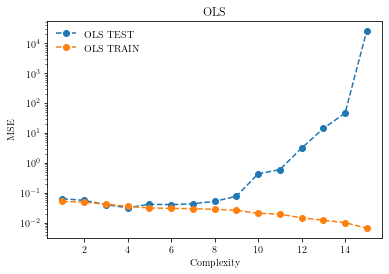

In [3]:
degree_values = np.arange(1,max_degree+1)
plt.semilogy(degree_values, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degree_values, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)

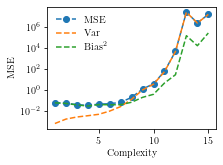

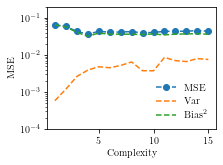

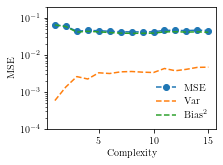

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ols_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)
plt.tight_layout()

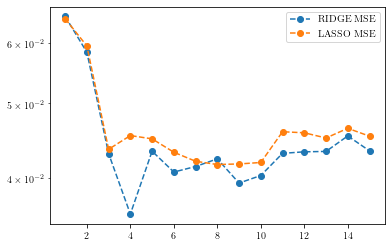

In [5]:
#plt.semilogy(degree_values, ols_boot_mse,"o--",label="OLS MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.legend()

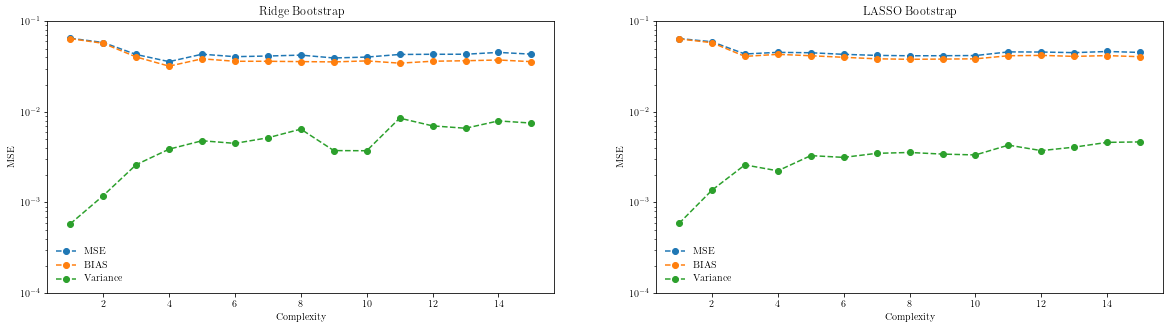

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

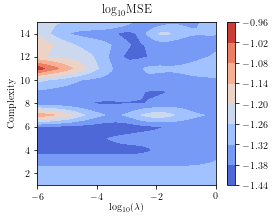

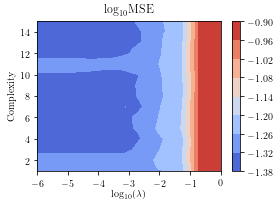

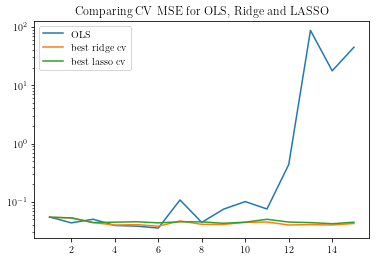

In [7]:
# CONTOUR PLOTS

# RIDGE
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(ridge_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")


# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(lasso_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")
plt.tight_layout()

# CV MSE for OLS, Ridge and LASSO:
plt.figure()
plt.semilogy(degree_values, ols_cv_mse, label ='OLS')
plt.semilogy(degree_values, best_ridge_mse, label="best ridge cv")
plt.semilogy(degree_values, best_lasso_mse, label="best lasso cv")
plt.legend()
plt.title('Comparing CV MSE for OLS, Ridge and LASSO')
plt.show()

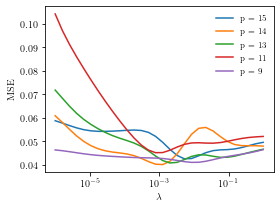

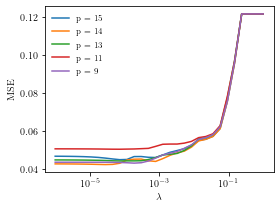

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')


# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')

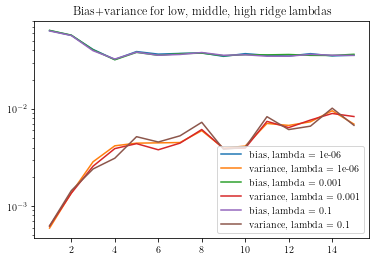

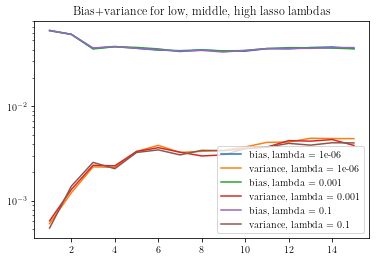

In [9]:
plt.figure()
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high ridge lambdas")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high lasso lambdas")
plt.legend()
plt.show()

In [10]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 1.00000000e+00 2.21221629e-02 7.88046282e-04
 4.52035366e-05 4.89390092e-04 4.89390092e-04 1.88739182e-04
 8.53167852e-03 2.21221629e-02 7.88046282e-04 2.04335972e-03
 2.04335972e-03 1.26896100e-03 5.29831691e-03]
[1.26896100e-03 2.04335972e-03 4.52035366e-05 4.89390092e-04
 7.27895384e-05 1.00000000e-06 1.17210230e-04 3.03919538e-04
 1.88739182e-04 3.03919538e-04 7.27895384e-05 7.27895384e-05
 7.27895384e-05 2.80721620e-05 7.27895384e-05]


In [11]:
n=200 #Try, corresponding to above, 200 and 1000
noise_scale=0.2 #Try, corresponding to above, 0.0 and 0.2
degree=6 # See how the best hyperparameters from CV-MSE above actually perform.
ridge_lambda=best_ridge_lambda[degree-1] # Ditto, remember the indexing 0 corresponds to degree 1
lasso_lambda=best_lasso_lambda[degree-1] # Ditto
plot_grid_size=2000

np.random.seed(SEEDVAL)
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

# Setting up plotting grid
x_plot = np.linspace(0, 1, plot_grid_size)
y_plot = np.linspace(0, 1, plot_grid_size)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]

z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(plot_grid_size, -1)

# Ridge

betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(plot_grid_size, -1)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False, max_iter=10000).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(plot_grid_size, -1)


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.291644756171948, tolerance: 0.002432716611271192
  positive)


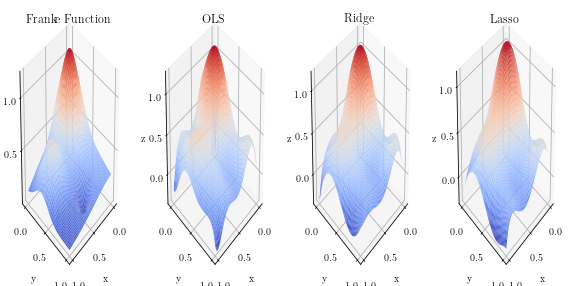

In [12]:
fig = plt.figure(figsize=(10,5))

# Plot the analytic curve
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
# Plot the Ridge
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
# Plot the Lasso
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)


In [13]:
print(stat_tools.MSE(z_plot_franke, z_predict_ols)) #Prediction MSE for OLS
print(stat_tools.MSE(z_plot_franke, z_predict_ridge)) # for Ridge
print(stat_tools.MSE(z_plot_franke, z_predict_lasso)) # for Lasso

0.0072167784806114075
0.005162524847593943
0.005948201232711926
